Navigate to <code>/chest_xray_code/data</code> and run 
<code>wget https://openi.nlm.nih.gov/imgs/collections/NLMCXR_png.tgz</code>
<code>wget https://openi.nlm.nih.gov/imgs/collections/NLMCXR_reports.tgz</code>

Then decompress them, and make sure they're in a directory called <code>/raw_reports</code> and <code>/xrays</code> respectively... (one of them decompresses to its own directory, so you need to rename that directory raw_reports instead of encgn or whatever).


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import matplotlib.pyplot as plt

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import glob
import os.path as osp
from PIL import Image

import torchvision.datasets as dset
import torchvision.transforms as T
import chest_xray_code.data.xrays as preprocess_dataset
import chest_xray_code.data.raw_reports as utils
import os
import torch.nn.functional as F


import numpy as np

Navigate to final_proj_code/chest_xray_code/src and run 

<code> python preprocess_dataset.py </code>

Now the data is stored in a numpy array in <code>../data/dataset.npy</code> 

In [5]:
#X, Y = utils.load_X_and_Y()
#x_train, x_dev, x_test = X
#y_train, y_dev, y_test = Y

class Data_SET(Dataset):
    """
    A customized data loader for MNIST.
    """
    def __init__(self,
                 root,
                 transform=None,
                 preload=False):
        """ Intialize the MNIST dataset
        
        Args:
            - root: root directory of the dataset
            - tranform: a custom tranform function
            - preload: if preload the dataset into memory
        """
        self.images = None
        self.labels = None
        self.filenames = []
        self.root = root
        self.transform = transform

        # read filenames
        filenames = glob.glob(osp.join(root, '*.jpg'))
        i = 0
        for fn in filenames:
            #print('in loop',fn)
            self.filenames.append(fn) # (filename, label) pair
            i +=1
            if i == 300:
                break

        # if preload dataset into memory
        if preload:
            self._preload()
            
        self.len = len(self.filenames)
                              
    def _preload(self):
        """
        Preload dataset to memory
        """
        self.labels = []
        self.images = []
        for image_fn in self.filenames:            
            # load images
            image = Image.open(image_fn)
            # avoid too many opened files bug
            self.images.append(image.copy())
            image.close()
            #self.labels.append(label)

    def __getitem__(self, index):
        """ Get a sample from the dataset
        """
        if self.images is not None:
            # If dataset is preloaded
            image = self.images[index]
            #label = self.labels[index]
        else:
            # If on-demand data loading
            image_fn = self.filenames[index]
            image = Image.open(image_fn)
            
        # May use transform function to transform samples
        # e.g., random crop, whitening
        if self.transform is not None:
            image = self.transform(image)
        # return image and label
        return image[:,100:300,100:300]

    def __len__(self):
        """
        Total number of samples in the dataset
        """
        return self.len
    
trainset = Data_SET(
    root='blood_cells_data/dataset-master/JPEGImages',
    preload=False, transform=transforms.ToTensor(),
)
# Use the torch dataloader to iterate through the dataset
trainset_loader = DataLoader(trainset, batch_size=64, shuffle=True, num_workers=24)

# load the testset
# testset = Data_SET(
#     root='chest_xray_code/data/xrays',
#     preload=True, transform=transforms.ToTensor(),
# )
#testset = trainset
# Use the torch dataloader to iterate through the dataset
#testset_loader = DataLoader(testset, batch_size=1000, shuffle=False, num_workers=1)

print(len(trainset))

300


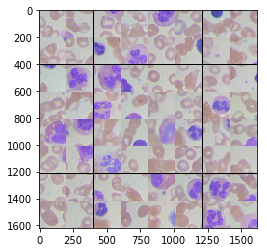

In [6]:
def imshow_noax(img, normalize=True):
    """ Tiny helper to show images as uint8 and remove axis labels """
    if normalize:
        img_max, img_min = np.max(img), np.min(img)
        img = 255.0 * (img - img_min) / (img_max - img_min)
    plt.imshow(img)
    plt.gca().axis('off')
    
    # functions to show an image
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# get some random training images
dataiter = iter(trainset_loader)
images = dataiter.next()


# show images
imshow(torchvision.utils.make_grid(images))


In [7]:
NUM_TRAIN = 100

# The torchvision.transforms package provides tools for preprocessing data
# and for performing data augmentation; here we set up a transform to
# preprocess the data by subtracting the mean RGB value and dividing by the
# standard deviation of each RGB value; we've hardcoded the mean and std.
transform = T.Compose([
                T.ToTensor()
                #T.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
            ])

# We set up a Dataset object for each split (train / val / test); Datasets load
# training examples one at a time, so we wrap each Dataset in a DataLoader which
# iterates through the Dataset and forms minibatches. We divide the CIFAR-10
# training set into train and val sets by passing a Sampler object to the
# DataLoader telling how it should sample from the underlying Dataset.
#cifar10_train = dset.CIFAR10('./cs231n/datasets', train=True, download=True,
#                             transform=transform)
# loader_train = DataLoader(cifar10_train, batch_size=64, 
#                           sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))
loader_train = trainset

#cifar10_val = dset.CIFAR10('./cs231n/datasets', train=True, download=True,
#                           transform=transform)
#loader_val = DataLoader(cifar10_val, batch_size=64, 
#                        sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN, 150)))

#cifar10_test = dset.CIFAR10('./cs231n/datasets', train=False, download=True, 
#                            transform=transform)
#loader_test = DataLoader(cifar10_test, batch_size=64)
#loader_test = testset

images = {}

You have an option to **use GPU by setting the flag to True below**. It is not necessary to use GPU for this assignment. Note that if your computer does not have CUDA enabled, `torch.cuda.is_available()` will return False and this notebook will fallback to CPU mode.

The global variables `dtype` and `device` will control the data types throughout this assignment. 

In [8]:
USE_GPU = True

dtype = torch.float32 # we will be using float throughout this tutorial

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
    #dtype = torch.cuda.FloatTensor
else:
    device = torch.device('cpu')

# Constant to control how frequently we print train loss
print_every = 5

print('using device:', device)

using device: cuda


In [9]:
def flatten(x):
    N = x.shape[0] # read in N, C, H, W
    return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image

def test_flatten():
    x = torch.arange(12).view(2, 1, 3, 2)
    print('Before flattening: ', x)
    print('After flattening: ', flatten(x))

### Module API: Check Accuracy
Given the validation or test set, we can check the classification accuracy of a neural network. 

This version is slightly different from the one in part II. You don't manually pass in the parameters anymore.

In [10]:
def check_accuracy_part34(loader, model):  
    num_correct = 0
    num_samples = 0
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for x in loader:
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            #y = y.to(device=device, dtype=torch.long)
            scores = model(x)

        
    i = 0
    for image in x:
        images[image] = scores[i]
        i += 1

### Module API: Training Loop
We also use a slightly different training loop. Rather than updating the values of the weights ourselves, we use an Optimizer object from the `torch.optim` package, which abstract the notion of an optimization algorithm and provides implementations of most of the algorithms commonly used to optimize neural networks.

# Part IV. PyTorch Sequential API

Part III introduced the PyTorch Module API, which allows you to define arbitrary learnable layers and their connectivity. 

For simple models like a stack of feed forward layers, you still need to go through 3 steps: subclass `nn.Module`, assign layers to class attributes in `__init__`, and call each layer one by one in `forward()`. Is there a more convenient way? 

Fortunately, PyTorch provides a container Module called `nn.Sequential`, which merges the above steps into one. It is not as flexible as `nn.Module`, because you cannot specify more complex topology than a feed-forward stack, but it's good enough for many use cases.

### Sequential API: Two-Layer Network
Let's see how to rewrite our two-layer fully connected network example with `nn.Sequential`, and train it using the training loop defined above.

Again, you don't need to tune any hyperparameters here, but you shoud achieve above 40% accuracy after one epoch of training.

In [8]:
def train_part34(model, optimizer, epochs=5):
    """
    Train a model on CIFAR-10 using the PyTorch Module API.
    
    Inputs:
    - model: A PyTorch Module giving the model to train.
    - optimizer: An Optimizer object we will use to train the model
    - epochs: (Optional) A Python integer giving the number of epochs to train for
    
    Returns: Nothing, but prints model accuracies during training.
    """
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    model = torch.nn.DataParallel(model)
    loss_history = []
    j = 0
    for e in range(epochs):       
        for batch_idx, (data) in enumerate(trainset_loader):
            data= data.to(device)
            optimizer.zero_grad()
            reconstruction = model(data)
            loss_function = nn.MSELoss(size_average=True)
            loss = loss_function(reconstruction, data)

            optimizer.zero_grad()

            loss.backward()
            loss_history.append(loss.item())
            optimizer.step()
  
        if e % print_every == 0:
            print('Iteration %d, loss = %.4f' % (e, loss.item()))
            #check_accuracy_part34(loader_val, model)
            print()

# Part V. CIFAR-10 open-ended challenge

In [9]:
################################################################################
# TODO:                                                                        #         
# Experiment with any architectures, optimizers, and hyperparameters.          #
# Achieve AT LEAST 70% accuracy on the *validation set* within 10 epochs.      #
#                                                                              #
# Note that you can use the check_accuracy function to evaluate on either      #
# the test set or the validation set, by passing either loader_test or         #
# loader_val as the second argument to check_accuracy. You should not touch    #
# the test set until you have finished your architecture and  hyperparameter   #
# tuning, and only run the test set once at the end to report a final value.   #
################################################################################
class TestConvNet(nn.Module):
    def __init__(self,channels,size):
        super().__init__()

        self.conv_1_compress = nn.Conv2d(channels, size, kernel_size=3,stride=1,padding=1,bias=True)
        self.relu_1_compress = nn.ReLU()
        
        self.conv_2_compress = nn.Conv2d(size, size, kernel_size=3,stride=1,padding=1,bias=True)
        self.batchnorm_2_compress = nn.BatchNorm2d(size)
        self.relu_2_compress = nn.ReLU()
        
        self.conv_3_compress = nn.Conv2d(size, size, kernel_size=3,stride=1,padding=1,bias=True)
        self.batchnorm_3_compress = nn.BatchNorm2d(size)
        self.relu_3_compress = nn.ReLU()
        
        self.conv_4_compress = nn.Conv2d(size, size, kernel_size=3,stride=1,padding=1,bias=True)
        self.batchnorm_4_compress = nn.BatchNorm2d(size)
        self.relu_4_compress = nn.ReLU()
        
        self.conv_5_compress = nn.Conv2d(size, size, kernel_size=3,stride=1,padding=1,bias=True)
        self.batchnorm_5_compress = nn.BatchNorm2d(size)
        self.relu_5_compress = nn.ReLU()
        
        self.conv_6_compress = nn.Conv2d(size, size, kernel_size=3,stride=1,padding=1,bias=True)
        self.batchnorm_6_compress = nn.BatchNorm2d(size)
        self.relu_6_compress = nn.ReLU()

        self.conv_downsize_compress = nn.Conv2d(size, size, kernel_size=3,stride=2,padding=1,bias=True)
        self.batchnorm_downsize_compress = nn.BatchNorm2d(size)
        self.relu_downsize_compress = nn.ReLU()
        
        self.conv_7_compress = nn.Conv2d(size, size, kernel_size=3,stride=1,padding=1,bias=True)
        self.batchnorm_7_compress = nn.BatchNorm2d(size)
        self.relu_7_compress = nn.ReLU()
        
        self.conv_8_compress = nn.Conv2d(size, size, kernel_size=3,stride=1,padding=1,bias=True)
        self.batchnorm_8_compress = nn.BatchNorm2d(size)
        self.relu_8_compress = nn.ReLU()
        
        self.conv_9_compress = nn.Conv2d(size, size, kernel_size=3,stride=1,padding=1,bias=True)
        self.batchnorm_9_compress = nn.BatchNorm2d(size)
        self.relu_9_compress = nn.ReLU()
        
        self.conv_10_compress = nn.Conv2d(size, size, kernel_size=3,stride=1,padding=1,bias=True)
        self.batchnorm_10_compress = nn.BatchNorm2d(size)
        self.relu_10_compress = nn.ReLU()
        
        
        
        self.conv_compress_final = nn.Conv2d(size, channels, kernel_size=3,stride=1,padding=1,bias=True)
        
        self.upscaling = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        
        self.conv_1_decompress = nn.Conv2d(channels, size, kernel_size=3,stride=1,padding=1,bias=True)
        self.relu_1_decompress = nn.ReLU()
        
        self.conv_2_decompress = nn.Conv2d(size, size, kernel_size=3,stride=1,padding=1,bias=True)
        self.batchnorm_2_decompress = nn.BatchNorm2d(size)
        self.relu_2_decompress = nn.ReLU()
        
        self.conv_3_decompress = nn.Conv2d(size, size, kernel_size=3,stride=1,padding=1,bias=True)
        self.batchnorm_3_decompress = nn.BatchNorm2d(size)
        self.relu_3_decompress = nn.ReLU()
        
        self.conv_4_decompress = nn.Conv2d(size, size, kernel_size=3,stride=1,padding=1,bias=True)
        self.batchnorm_4_decompress = nn.BatchNorm2d(size)
        self.relu_4_decompress = nn.ReLU()
        
        self.conv_5_decompress = nn.Conv2d(size, size, kernel_size=3,stride=1,padding=1,bias=True)
        self.batchnorm_5_decompress = nn.BatchNorm2d(size)
        self.relu_5_decompress = nn.ReLU()
        
        self.conv_6_decompress = nn.Conv2d(size, size, kernel_size=3,stride=1,padding=1,bias=True)
        self.batchnorm_6_decompress = nn.BatchNorm2d(size)
        self.relu_6_decompress = nn.ReLU()
        
        self.conv_7_decompress = nn.Conv2d(size, size, kernel_size=3,stride=1,padding=1,bias=True)
        self.batchnorm_7_decompress = nn.BatchNorm2d(size)
        self.relu_7_decompress = nn.ReLU()
        
        self.conv_8_decompress = nn.Conv2d(size, size, kernel_size=3,stride=1,padding=1,bias=True)
        self.batchnorm_8_decompress = nn.BatchNorm2d(size)
        self.relu_8_decompress = nn.ReLU()
        
        self.conv_9_decompress = nn.Conv2d(size, size, kernel_size=3,stride=1,padding=1,bias=True)
        self.batchnorm_9_decompress = nn.BatchNorm2d(size)
        self.relu_9_decompress = nn.ReLU()
        
        self.conv_10_decompress = nn.Conv2d(size, 3, kernel_size=3,stride=1,padding=1,bias=True)
        

    def forward(self, x):
        scores = None
        model = torch.nn.Sequential( 
            
            self.conv_1_compress,
            self.relu_1_compress,
        
            self.conv_2_compress,
            self.batchnorm_2_compress,
            self.relu_2_compress,
            
            self.conv_3_compress,
            self.batchnorm_3_compress,
            self.relu_3_compress,
            
            self.conv_4_compress,
            self.batchnorm_4_compress,
            self.relu_4_compress,
            
            self.conv_5_compress,
            self.batchnorm_5_compress,
            self.relu_5_compress,
            
            self.conv_6_compress,
            self.batchnorm_6_compress,
            self.relu_6_compress,
            
            self.conv_downsize_compress,
            self.batchnorm_downsize_compress,
            self.relu_downsize_compress,
            
            self.conv_7_compress,
            self.batchnorm_7_compress,
            self.relu_7_compress,
            
            self.conv_8_compress,
            self.batchnorm_8_compress,
            self.relu_8_compress,
            
            self.conv_9_compress,
            self.batchnorm_9_compress,
            self.relu_9_compress,
            
            self.conv_10_compress,
            self.batchnorm_10_compress,
            self.relu_10_compress,
            
            self.conv_compress_final,
        
            self.upscaling,
            
            self.conv_1_decompress,
            self.relu_1_decompress,
        
            self.conv_2_decompress,
            self.batchnorm_2_decompress,
            self.relu_2_decompress,
            
            self.conv_3_decompress,
            self.batchnorm_3_decompress,
            self.relu_3_decompress,
            
            self.conv_4_decompress,
            self.batchnorm_4_decompress,
            self.relu_4_decompress,
            
            self.conv_5_decompress,
            self.batchnorm_5_decompress,
            self.relu_5_decompress,
            
            self.conv_6_decompress,
            self.batchnorm_6_decompress,
            self.relu_6_decompress,
            
            self.conv_7_decompress,
            self.batchnorm_7_decompress,
            self.relu_7_decompress,
            
            self.conv_8_decompress,
            self.batchnorm_8_decompress,
            self.relu_8_decompress,
            
            self.conv_9_decompress,
            self.batchnorm_9_decompress,
            self.relu_9_decompress,
        
            self.conv_10_decompress

            
        ).to(device)
        scores = model(x)
        return scores
    


class Flatten(nn.Module):
    def forward(self, x):
        x = x.view(x.size()[0], -1)
        return x

channels = 3
size = 32

model = TestConvNet(channels, size)
optimizer = optim.Adam(model.parameters(), lr=5e-3)
                     #momentum=0.9, nesterov=True)#optim.SGD(model.parameters(), lr=5e-3)

################################################################################
#                                 END OF YOUR CODE                             
################################################################################

# You should get at least 70% accuracy
train_part34(model, optimizer, epochs=2500)

 

Iteration 0, loss = 0.0847

Iteration 5, loss = 0.0074

Iteration 10, loss = 0.0035

Iteration 15, loss = 0.0046



Process Process-441:
Process Process-455:
Process Process-442:
Process Process-445:
Process Process-450:
Process Process-452:
Process Process-439:
Process Process-438:
Process Process-453:
Process Process-444:
Process Process-434:
Process Process-440:
Process Process-448:
Process Process-446:
Process Process-443:
Process Process-451:
Process Process-436:
Process Process-449:
Process Process-433:
Process Process-456:
Process Process-447:
Process Process-454:
Process Process-437:
Process Process-435:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceb

  File "/home/shared/anaconda3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 52, in _worker_loop
    r = index_queue.get()
  File "/home/shared/anaconda3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 52, in _worker_loop
    r = index_queue.get()
  File "/home/shared/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/shared/anaconda3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 52, in _worker_loop
    r = index_queue.get()
  File "/home/shared/anaconda3/lib/python3.6/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/home/shared/anaconda3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 52, in _worker_loop
    r = index_queue.get()
  File "/home/shared/anaconda3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 52, in _worker_loop
    r = index_queue.get()
  File "/home/shared/an

  File "/home/shared/anaconda3/lib/python3.6/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
  File "/home/shared/anaconda3/lib/python3.6/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/home/shared/anaconda3/lib/python3.6/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/home/shared/anaconda3/lib/python3.6/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/home/shared/anaconda3/lib/python3.6/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
  File "/home/shared/anaconda3/lib/python3.6/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/home/shared/anaconda3/lib/python3.6/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
  File "/home/shared/anaconda3/lib/python3.6/multiprocessing/conne

Traceback (most recent call last):
  File "/home/shared/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-9-a4c3d05bfc8e>", line 215, in <module>
    train_part34(model, optimizer, epochs=2500)
  File "<ipython-input-8-7ccda91b5386>", line 20, in train_part34
    reconstruction = model(data)
  File "/home/shared/anaconda3/lib/python3.6/site-packages/torch/nn/modules/module.py", line 491, in __call__
    result = self.forward(*input, **kwargs)
  File "/home/shared/anaconda3/lib/python3.6/site-packages/torch/nn/parallel/data_parallel.py", line 114, in forward
    outputs = self.parallel_apply(replicas, inputs, kwargs)
  File "/home/shared/anaconda3/lib/python3.6/site-packages/torch/nn/parallel/data_parallel.py", line 124, in parallel_apply
    return parallel_apply(replicas, inputs, kwargs, self.device_ids[:len(replicas)])
  File "/home/shared/anaconda3/lib/python3.6

KeyboardInterrupt: 

In [11]:
# get some random training images
# dataiter = iter(trainset_loader)
# images = dataiter.next()




originals = originals.to(device=device, dtype=dtype)
reconstruction = model(originals)
#for i in range(20):
#    plt.figure()
#    org = originals[i].cpu().detach().numpy().transpose(1,2,0)
#    plt.subplot(1, 2, 1)
#    imshow_noax(original.detach().numpy().transpose(1,2,0), normalize=False)
#    plt.title('Original image')
#    plt.subplot(1, 2, 2)
#    rec = reconstruction.detach().numpy().transpose(1,2,0)
#    imshow_noax(reconstruction.detach().numpy().transpose(1,2,0), normalize=False)
#    plt.title('Reconstructed image')
#    plt.show()
    #imshow(torchvision.utils.make_grid(originals[i].cpu()))
    #imshow(torchvision.utils.make_grid(reconstruction[i].detach().cpu()))
#    break
    

#reconstruction = model(pic)
# show images
#imshow(torchvision.utils.make_grid(pic))
# print labels
#print(' '.join('%5s' % labels[j] for j in range(5)))

NameError: name 'originals' is not defined

In [ ]:


for i in range(20):
    plt.figure()
    org = originals[i].cpu().detach().numpy().transpose(1,2,0)
    plt.subplot(1, 2, 1)
    imshow_noax(org, normalize=False)
    plt.title('Original image')
    plt.subplot(1, 2, 2)
    rec = reconstruction[i].cpu().detach().numpy().transpose(1,2,0)
    imshow_noax(rec, normalize=False)
    plt.title('Reconstructed image')
    plt.show()

